### <center> Image Denoising using Shearlets </center>

In [1]:
# Clone the libraris
#Pkg.clone("https://github.com/arsenal9971/Shearlab.jl.git")

In [1]:
# Loard the Pkg
push!(LOAD_PATH,pwd()*"/../../src") 
import Shearlab
#using Shearlab
using PyPlot
#reload("Shearlab")

In [6]:
# Read Data
n = 512;
# The path of the image
name = "../../data_samples/lena.jpg";
data_nopar = Shearlab.load_image(name, n);
data_par = Shearlab.load_image(name, n,n,1);
#Rescale image in [0,1] summing the 3 arrays in the RGB format
#data = Shearlab.rescale(sum(data,3)); this time no rescaling ; 

In [3]:
nScales = 4;
shearLevels = ceil((1:nScales)/2)
scalingFilter = Shearlab.filt_gen("scaling_shearlet");
directionalFilter = Shearlab.filt_gen("directional_shearlet");
waveletFilter = Shearlab.mirror(scalingFilter);
scalingFilter2 = scalingFilter;
full = 0;

In [7]:
# Reduce one dimension 
data_par = data_par[:,:,1];
data_nopar = data_nopar[:,:,1];

In [8]:
# settings
sigma = 30;
scales = 4;
thresholdingFactor = 3;

In [9]:
# Give noise to data
X_nopar = data_nopar;
Xnoisy_nopar = X_nopar + sigma*randn(size(X_nopar));

In [10]:
# GPU version
using ArrayFire

In [11]:
# Give noise to data
X_par = AFArray(convert(Array{Float32},data_par));
Xnoisy_par = X_par + AFArray(sigma*randn(Float32,size(X_par)));

In [12]:
# Get the Shearlet system 
@time shearletSystem_nopar = Shearlab.getshearletsystem2D(size(X_nopar,1), size(X_nopar,2), scales,shearLevels,full,directionalFilter,scalingFilter,0);

 15.870198 seconds (8.82 M allocations: 5.376 GB, 23.75% gc time)


In [13]:
# Get the Shearlet system in parallel
@time shearletSystem_par = Shearlab.getshearletsystem2D(size(X_par,1), size(X_par,2), scales,shearLevels,full,directionalFilter,scalingFilter,1);

  7.469600 seconds (1.93 M allocations: 579.785 MB, 3.38% gc time)


In [14]:
# Decomposition
@time coeffs_nopar = Shearlab.sheardec2D( Xnoisy_nopar, shearletSystem_nopar);

  1.335661 seconds (24.37 k allocations: 1.355 GB, 28.43% gc time)


In [15]:
# Decomposition with gpu
@time coeffs_par = Shearlab.sheardec2D( Xnoisy_par, shearletSystem_par);

  0.816827 seconds (549.96 k allocations: 122.095 MB, 3.11% gc time)


In [16]:
# Thresholding
@time coeffs_nopar = coeffs_nopar.*(abs(coeffs_nopar).> thresholdingFactor*reshape(repmat(shearletSystem_nopar.RMS',size(X_nopar,1)*size(X_nopar,2), 1),
        size(X_nopar,1),size(X_nopar,2),length(shearletSystem_nopar.RMS))*sigma);

  1.073723 seconds (802.71 k allocations: 616.119 MB, 16.56% gc time)


In [17]:
# Thresholding with gpu
@time coeffs_par = coeffs_par.*AFArray(convert(Array{Float32},(abs(Array(coeffs_par)).> (e^11)*thresholdingFactor*reshape(repmat(Array(shearletSystem_par.RMS'),size(X_par,1)*size(X_par,2), 1),
        size(X_par,1),size(X_par,2),length(shearletSystem_par.RMS))*sigma)));

  1.037575 seconds (745.12 k allocations: 369.622 MB, 24.78% gc time)


In [20]:
# Reconstruction
Xrec_nopar = Shearlab.shearrec2D(coeffs_nopar, shearletSystem_nopar);
Xrec_par = Shearlab.shearrec2D(coeffs_par, shearletSystem_par);

### Results

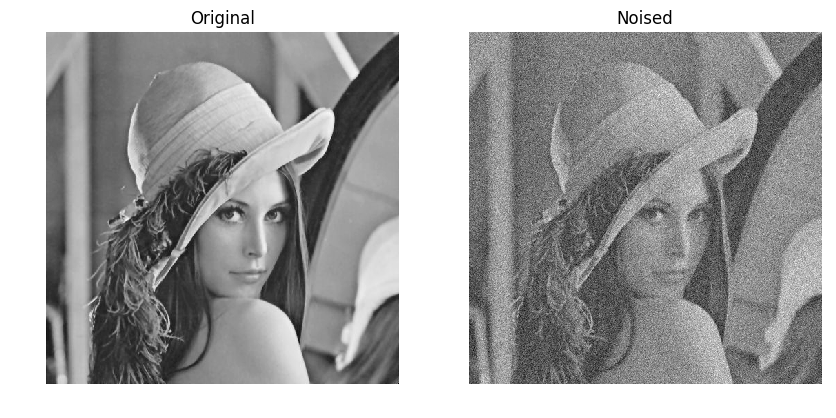

In [21]:
# display
clf;
figure(figsize=(10,10));
Shearlab.imageplot(Array(X_nopar), "Original", 1,2,1); 
Shearlab.imageplot(Array(Xnoisy_nopar), "Noised", 1,2,2); 

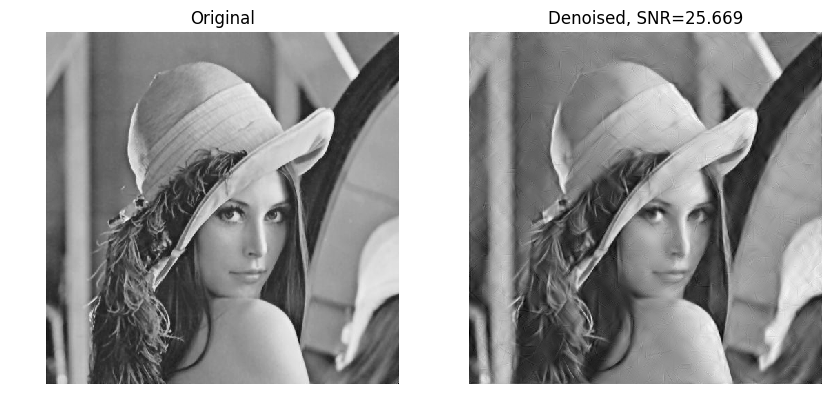

In [22]:
elin = Shearlab.snr(Array(X_nopar),Array(Xrec_nopar));
# display
clf;
figure(figsize=(10,10));
Shearlab.imageplot(Array(X_nopar), "Original", 1,2,1); 
u = @sprintf("Denoised, SNR=%.3f", elin);
Shearlab.imageplot(real(Array(Xrec_nopar)), u, 1,2,2);